<a href="https://colab.research.google.com/github/OliviaHutchison/IMLOProject/blob/Tutorials/Pytorch_Tutorial_pt_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Pytorch Tutorial</h1>

<h2>QuickStart</h2>
<a href="https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html">Here</a>

<h3> Working with Data</h3>

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader ##wraps an iterable around dataset
from torchvision import datasets ##stores data samples
from torchvision.transforms import ToTensor

Pytorch has domain-specific libraries: TorchText, TorchVision and TorchAudio, all including datasets.  

In [2]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 26421880/26421880 [00:00<00:00, 37564817.98it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 51282055.74it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 28321893.86it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 11995709.44it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


<h3>Creating Models</h3>
<p>To define a neural network in PyTorch, we create a class that inherits from nn.Module. We define the layers of the network in the __init__ function and specify how data will pass through the network in the forward function. To accelerate operations in the neural network, we move it to the GPU or MPS if available.</p>

In [4]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [5]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


<h3>Optimising Model Params</h3>
<p>To train a model, we need a loss function and an optimizer.</p>

In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

<p>In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and backpropagates the prediction error to adjust the model’s parameters.</p>

In [7]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

<p>We also check the model’s performance against the test dataset to ensure it is learning.</p>

In [8]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

<p>The training process is conducted over several iterations (epochs). During each epoch, the model learns parameters to make better predictions. We print the model’s accuracy and loss at each epoch; we’d like to see the accuracy increase and the loss decrease with every epoch.</p>

In [9]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.299273  [   64/60000]
loss: 2.294131  [ 6464/60000]
loss: 2.272972  [12864/60000]
loss: 2.272127  [19264/60000]
loss: 2.252010  [25664/60000]
loss: 2.222274  [32064/60000]
loss: 2.242595  [38464/60000]
loss: 2.207497  [44864/60000]
loss: 2.200993  [51264/60000]
loss: 2.174104  [57664/60000]
Test Error: 
 Accuracy: 38.4%, Avg loss: 2.162072 

Epoch 2
-------------------------------
loss: 2.170771  [   64/60000]
loss: 2.168201  [ 6464/60000]
loss: 2.106468  [12864/60000]
loss: 2.119503  [19264/60000]
loss: 2.080844  [25664/60000]
loss: 2.013211  [32064/60000]
loss: 2.056411  [38464/60000]
loss: 1.975528  [44864/60000]
loss: 1.977612  [51264/60000]
loss: 1.916178  [57664/60000]
Test Error: 
 Accuracy: 54.8%, Avg loss: 1.905815 

Epoch 3
-------------------------------
loss: 1.938654  [   64/60000]
loss: 1.918464  [ 6464/60000]
loss: 1.792629  [12864/60000]
loss: 1.827088  [19264/60000]
loss: 1.736821  [25664/60000]
loss: 1.672481  [32064/600

<h3>Saving and Loading Models</h3>
<p>A common way to save a model is to serialize the internal state dictionary (containing the model parameters). See:</p> <a href="https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html">Pytorch Quickstart</a>

<h2>Tensors</h2>
<a href="https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html">Here</a>
<p>**Tensors** are a specialized data structure that are very similar to arrays and matrices. In PyTorch, we use tensors to encode the inputs and outputs of a model, as well as the model’s parameters.

Tensors are similar to **NumPy**’s ndarrays, except that tensors can run on GPUs or other hardware accelerators. In fact, tensors and NumPy arrays can often share the same underlying memory, eliminating the need to copy data (see Bridge with NumPy). Tensors are also optimized for automatic differentiation (we’ll see more about that later in the Autograd section). If you’re familiar with ndarrays, you’ll be right at home with the Tensor API. If not, follow along!</p>

In [10]:
import torch
import numpy as np

<h3>Initialising a Tensor</h3>
Various ways.

In [11]:
##Directly form Data
data = [[1, 2],[3, 4]]
x_data = torch.tensor(data)

In [12]:
##From NumPy array
np_array = np.array(data)
x_np = torch.from_numpy(np_array)

In [13]:
##From another Tensor
x_ones = torch.ones_like(x_data) # retains the properties of x_data
print(f"Ones Tensor: \n {x_ones} \n")

x_rand = torch.rand_like(x_data, dtype=torch.float) # overrides the datatype of x_data
print(f"Random Tensor: \n {x_rand} \n")

Ones Tensor: 
 tensor([[1, 1],
        [1, 1]]) 

Random Tensor: 
 tensor([[0.8552, 0.2423],
        [0.7961, 0.2091]]) 



In [14]:
##With Random or constant values
shape = (2,3,)
rand_tensor = torch.rand(shape)
ones_tensor = torch.ones(shape)
zeros_tensor = torch.zeros(shape)

print(f"Random Tensor: \n {rand_tensor} \n")
print(f"Ones Tensor: \n {ones_tensor} \n")
print(f"Zeros Tensor: \n {zeros_tensor}")

Random Tensor: 
 tensor([[0.1157, 0.5437, 0.4550],
        [0.8643, 0.7758, 0.8542]]) 

Ones Tensor: 
 tensor([[1., 1., 1.],
        [1., 1., 1.]]) 

Zeros Tensor: 
 tensor([[0., 0., 0.],
        [0., 0., 0.]])


<h3>Attributes of Tensor</h3>

In [16]:
##Describe shape, datatype and device where stored
tensor = torch.rand(3,4)

print(f"Shape of tensor: {tensor.shape}")
print(f"Datatype of tensor: {tensor.dtype}")
print(f"Device tensor is stored on: {tensor.device}")

Shape of tensor: torch.Size([3, 4])
Datatype of tensor: torch.float32
Device tensor is stored on: cpu


<h3>Operations on Tensors</h3>
<p>Over 100 tensor operations, including arithmetic, linear algebra, matrix manipulation (transposing, indexing, slicing), sampling and more are comprehensively described</p><a href="https://pytorch.org/docs/stable/torch.html"> here.</a><p>

Each of these operations can be run on the GPU (at typically higher speeds than on a CPU). If you’re using Colab, allocate a GPU by going to Runtime > Change runtime type > GPU.

By default, tensors are created on the CPU. We need to explicitly move tensors to the GPU using .to method (after checking for GPU availability). Keep in mind that copying large tensors across devices can be expensive in terms of time and memory!</p>

In [17]:
# We move our tensor to the GPU if available
if torch.cuda.is_available():
    tensor = tensor.to("cuda")

<p>Similar to NumPy.</p>
<p>Few Trials:</p>

In [20]:
##Indexing and slicing
tensor = torch.ones(4, 4)
print(f"First row: {tensor[0]}")
print(f"First column: {tensor[:, 0]}")
print(f"Last column: {tensor[..., -1]}")
tensor[:,1] = 0 #changes 2nd coloumn value to 0
print(tensor)

First row: tensor([1., 1., 1., 1.])
First column: tensor([1., 1., 1., 1.])
Last column: tensor([1., 1., 1., 1.])
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


In [22]:
##Joining Tensors (also use torch stack)
t1 = torch.cat([tensor, tensor, tensor], dim=1)
print(t1)

tensor([[1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.]])


In [23]:
##Aritmetic
# This computes the matrix multiplication between two tensors. y1, y2, y3 will have the same value
# ``tensor.T`` returns the transpose of a tensor
y1 = tensor @ tensor.T
y2 = tensor.matmul(tensor.T)

y3 = torch.rand_like(y1)
torch.matmul(tensor, tensor.T, out=y3)


# This computes the element-wise product. z1, z2, z3 will have the same value
z1 = tensor * tensor
z2 = tensor.mul(tensor)

z3 = torch.rand_like(tensor)
torch.mul(tensor, tensor, out=z3)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])

In [24]:
##Single element Tensors
#If you have a one-element tensor, for example by aggregating all values of a tensor into one value, you can convert it to a Python numerical value using item()
agg = tensor.sum()
agg_item = agg.item()
print(agg_item, type(agg_item))

12.0 <class 'float'>


In [25]:
##In place ops
#Operations that store the result into the operand are called in-place. They are denoted by a _ suffix. For example: x.copy_(y), x.t_(), will change xOperations that store the result into the operand are called in-place. They are denoted by a _ suffix. For example: x.copy_(y), x.t_(), will change x
print(f"{tensor} \n")
tensor.add_(5)
print(tensor)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]]) 

tensor([[6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.]])


<h3>Bridge with NumPy</h3>
<p>Tensors on the CPU and NumPy arrays can share their underlying memory locations, and changing one will change the other.</p>

In [26]:
##Tensor to Np array
t = torch.ones(5)
print(f"t: {t}")
n = t.numpy()
print(f"n: {n}")

t: tensor([1., 1., 1., 1., 1.])
n: [1. 1. 1. 1. 1.]


In [27]:
#change in tensor reflects in Np array
t.add_(1)
print(f"t: {t}")
print(f"n: {n}")

t: tensor([2., 2., 2., 2., 2.])
n: [2. 2. 2. 2. 2.]


In [28]:
##Np Array to Tensor
n = np.ones(5)
t = torch.from_numpy(n)

In [29]:
#Changes in Np reflects in tensor
np.add(n, 1, out=n)
print(f"t: {t}")
print(f"n: {n}")

t: tensor([2., 2., 2., 2., 2.], dtype=torch.float64)
n: [2. 2. 2. 2. 2.]


<h2>Datasets and DataLoaders</h2>
<a href="https://pytorch.org/tutorials/beginner/basics/data_tutorial.html">Here</a>
<p>Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code to be decoupled from our model training code for better readability and modularity. PyTorch provides two data primitives: torch.utils.data.DataLoader and torch.utils.data.Dataset that allow you to use pre-loaded datasets as well as your own data. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.</p>

<h3>Loading a Dataset</h3>
<p>Example of loading the FashionMNIST Dataset</p>
<a href="https://research.zalando.com/project/fashion_mnist/fashion_mnist/">Dataset</a>
<p>We load the FashionMNIST Dataset with the following parameters:


*   root is the path where the train/test data is stored,
*   train specifies training or test dataset,
*   download=True downloads the data from the internet if it’s not available at root.
*   transform and target_transform specify the feature and label transformations

In [31]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

##Note: Already been downloaded in Quickstart
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

<h3>Iterating and Visualising</h3>
<p>Can index datasets manually like a list.  We can use matplotlib to visualise samples in training data.</p>

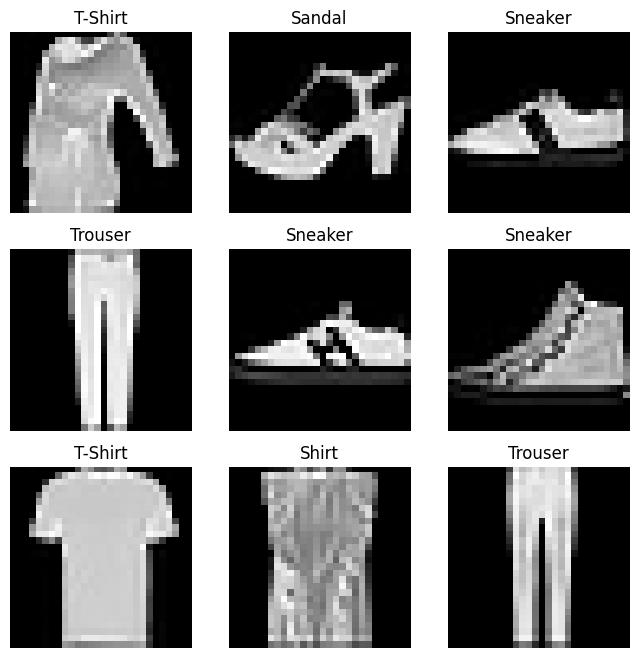

In [35]:
#All categories of items in dataset
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item() #gets random item
    img, label = training_data[sample_idx] #labels image based on sample training
    figure.add_subplot(rows, cols, i) #plots
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray") #greys the image
plt.show()

<h3>Creating Custom Dataset</p>
<p>Not necessary for the project so refer to tutorial page as you see fit</p>

<h3>Prepping Data for training</h3>
<p>The Dataset retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval.

DataLoader is an iterable that abstracts this complexity for us in an easy API.</p>

In [36]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

<h3>Iterate through DataLoader</h3>
<p>We have loaded that dataset into the DataLoader and can iterate through the dataset as needed. Each iteration below returns a batch of train_features and train_labels (containing batch_size=64 features and labels respectively). Because we specified shuffle=True, after we iterate over all batches the data is shuffled (for finer-grained control over the data loading order, take a look at <a href="https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler">Samplers</a>).</p>

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


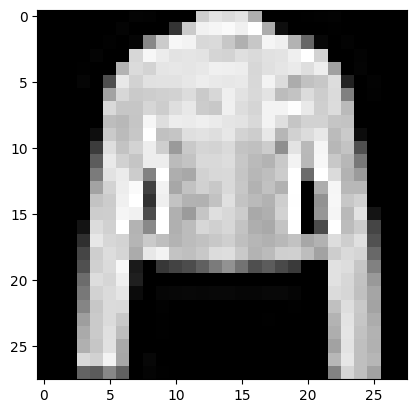

Label: 4


In [37]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

<h2>Transforms</h2>
<p>Data does not always come in its final processed form that is required for training machine learning algorithms. We use transforms to perform some manipulation of the data and make it suitable for training.

All TorchVision datasets have two parameters -transform to modify the features and target_transform to modify the labels - that accept callables containing the transformation logic. The <a href="https://pytorch.org/vision/stable/transforms.html">torchvision.transforms</a> module offers several commonly-used transforms out of the box.

The FashionMNIST features are in PIL Image format, and the labels are integers. For training, we need the features as normalized tensors, and the labels as one-hot encoded tensors. To make these transformations, we use ToTensor and Lambda.</p>

In [39]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

##Already downloaded from Quickstart
ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(), #ToTensor converts a PIL image or NumPy ndarray into a FloatTensor. and scales the image’s pixel intensity values in the range [0., 1.]
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

<h3>Lambda Transforms</h3>
<p>Lambda transforms apply any user-defined lambda function. Here, we define a function to turn the integer into a one-hot encoded tensor. It first creates a zero tensor of size 10 (the number of labels in our dataset) and calls scatter_ which assigns a value=1 on the index as given by the label y.</p>

In [40]:
target_transform = Lambda(lambda y: torch.zeros(
    10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))